# Neural style transfer

## Resources 
- [C4W4L06 What is neural style transfer?](https://www.youtube.com/watch?v=R39tWYYKNcI)
- [Intuitive Guide to Neural Style Transfer](https://towardsdatascience.com/light-on-math-machine-learning-intuitive-guide-to-neural-style-transfer-ef88e46697ee)

## Code Resources 
- https://pytorch.org/tutorials/advanced/neural_style_tutorial.html?highlight=neural%20style
- https://techyhans.com/neural-style-transfer/

## Video
- https://www.youtube.com/watch?v=imX4kSKDY7s
- https://www.youtube.com/playlist?list=PLBoQnSflObcmbfshq9oNs41vODgXG-608

## Paper
- [A Neural Algorithm of Artistic Style, Leon A. Gatys, Alexander S. Ecker, Matthias Bethge](https://arxiv.org/abs/1508.06576)

## Notes

- C is the Content image
- S is the Style image
- G is the Generated image
- Pseudo Plan
    - create a forward pass function or classs to get the C and S activation in layer l
    - initial look into single layer later look into mutiple layer
    - Cost = Content cost and style cost
    - content cost = l2 norm of the activation in layer l 
    - $$ L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2 $$
    - style cost = we need gram  matrix
    - what is gram matrix
    - create style only
    - create content only

***Before we neural syle transfer we should have clear understanding
about the computation made by the conv layers*** 

### imports

In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
torch.__version__

'1.8.1'

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

In [4]:
!pip install torchinfo

In [5]:
from torchinfo import summary

In [6]:
available_device = "cuda" if torch.cuda.is_available() else "cpu"
# available_device = "cpu"

print(f"{available_device} is available")
device = torch.device(device=available_device)
device

cuda is available


device(type='cuda')

In [7]:
!nvidia-smi

Sat Jun 26 23:13:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.31       Driver Version: 465.31       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:57:00.0 Off |                  N/A |
| N/A   38C    P0    11W /  N/A |      7MiB /  3911MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
transformImage2Tensor = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

transformTensor2Image = transforms.ToPILImage()

In [36]:
def show_tensor(batch, title=None):
    image = batch.cpu().clone()
    image = batch.squeeze(0)
    image = transformTensor2Image(image)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

    


## Loading Content and Style Image
| **Content** | **Style** |
|--- |--- |
| ![](./husky_1.jpg)| ![](./gogh.jpg)



In [10]:
content = Image.open("./husky_1.jpg")
style = Image.open("./gogh.jpg")

content_tensor = transformImage2Tensor(content).unsqueeze(0).to(device)
style_tensor = transformImage2Tensor(style).unsqueeze(0).to(device)
# generate_tensor = torch.rand(1,3,224,224).to(device) # copy the content rather than creating random

In [10]:
content_tensor.shape

torch.Size([1, 3, 224, 224])

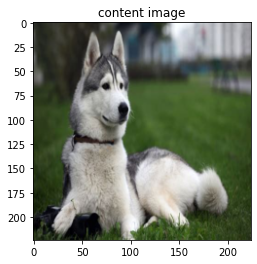

In [12]:
show_tensor(content_tensor, "content image")

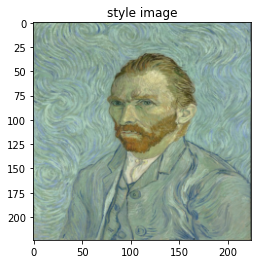

In [13]:
show_tensor(style_tensor, "style image")

## Loading pretrained VGG19 

In [14]:
torch.cuda.empty_cache()

In [ ]:
# vgg19_model = torchvision.models.vgg19(pretrained=True).to(device)
# for parameters in vgg19_model.parameters():
#     parameters.requires_grad = False
# print(vgg19_model.features)  # we only look only into features

In [ ]:
# features_vgg19 = list(vgg19_model.features)[:29]
# len(features_vgg19)

29

In [ ]:
# def forward_vgg19(model, x, layer_to_watch):
    
#     model.eval()
#     layer_activation = OrderedDict()
#     for layer_idx, layer in enumerate(model.features):    
#         x = layer(x)
#         if layer_idx in layer_to_watch:
#             layer_activation[layer_idx]  = x
#             # print(layer)
#             # print(layer_idx)
# #     break
#     return layer_activation

### Activation Extractor Model

In [11]:
class VGG_Activation(nn.Module):
    def __init__(self, layers_to_watch):
        super().__init__()
        self.vgg_features = torchvision.models.vgg19(pretrained=True).features
        
        # layers idx whose activations are to be stored
        self.layers_to_watch = layers_to_watch 
        
        # calling the hook setter 
        self.set_hooks() 

        # to keep the selected layers activation
        self.layer_activation = OrderedDict()

    def layer_watch_hooks(self, layer_idx):
        def hook(module, input, output):
            """Run  hook.
            hook(module, input, output) -> None or modified output
            Parameters
            ----------
            module : torch.nn.Module
                The layer we want to attach the hook to.
            inp : tuple of torch.Tensor
                The input to the `forward` method.
            out : torch.Tensor
                The output of the `forward` method.
            """
            # print(layer_idx)
            # print(module)
            self.layer_activation[layer_idx] = output
        return hook

    def selected_layers(self):
        for layer_idx, layer in enumerate(self.vgg_features):    
            if layer_idx in self.layers_to_watch:
                print(layer)
                
    def set_hooks(self):
        """
        setting hooks for the layers that matches the layer idx
        """
        for layer_idx, layer in enumerate(self.vgg_features):    
            if layer_idx in self.layers_to_watch:
                layer.register_forward_hook(self.layer_watch_hooks(layer_idx))

    def forward(self, x):
        self.vgg_features.eval()
        _ = self.vgg_features(x)
        return self.layer_activation.copy()

In [16]:
# style_layer_to_watch = [0, 5, 10, 19, 28]  # layers to get the activation from
# content_layer_to_watch = [21]  # layers to get the activation from


### initialize the activation function

In [17]:
layer_to_watch = [0, 5, 10, 19, 28]  # layers to get the activation from

vgg_layer_act = VGG_Activation(layer_to_watch).to(device)

In [19]:
summary(vgg_layer_act, input_size=(1, 3, 224, 224))
# [0, 5, 10, 19, 28]

Layer (type:depth-idx)                   Output Shape              Param #
VGG_Activation                           --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [20]:
vgg_layer_act.selected_layers()

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Content Activations

In [ ]:
# content_activation = forward_vgg19(vgg19_model, content_tensor, layer_to_watch)
# for ac in content_activation.values():
#     print(ac.shape)
#     print(ac.sum())
# content_activation.keys()  # keys refer to the layer activations which haave been recorded

In [21]:
content_activation = vgg_layer_act(content_tensor)
for ac in content_activation.values():
    print(ac.shape)
    print(ac.sum())
# y
content_activation.keys()

torch.Size([1, 64, 224, 224])
tensor(688046.1250, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 128, 112, 112])
tensor(520422.4688, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 256, 56, 56])
tensor(413084.4375, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 28, 28])
tensor(244597.5938, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 14, 14])
tensor(39358.8203, device='cuda:0', grad_fn=<SumBackward0>)


odict_keys([0, 5, 10, 19, 28])

### Style Activation

In [ ]:
# style_activation = forward_vgg19(vgg19_model, style_tensor, layer_to_watch)
# for ac in style_activation.values():
#     print(ac.shape)
#     print(ac.sum())
# style_activation.keys() # keys refer to the layer activations which haave been recorded

torch.Size([1, 64, 224, 224])
tensor(686116.8125, device='cuda:0')
torch.Size([1, 128, 112, 112])
tensor(522308.2500, device='cuda:0')
torch.Size([1, 256, 56, 56])
tensor(434120.9375, device='cuda:0')
torch.Size([1, 512, 28, 28])
tensor(290919.9688, device='cuda:0')
torch.Size([1, 512, 14, 14])
tensor(39427.4180, device='cuda:0')


odict_keys([0, 5, 10, 19, 28])

In [22]:
style_activation = vgg_layer_act(style_tensor)
for ac in style_activation.values():
    print(ac.shape)
    print(ac.sum())

style_activation.keys() # keys refer to the layer activations which haave been recorded

torch.Size([1, 64, 224, 224])
tensor(686116.8125, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 128, 112, 112])
tensor(522308.2500, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 256, 56, 56])
tensor(434120.9375, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 28, 28])
tensor(290920., device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 14, 14])
tensor(39427.4180, device='cuda:0', grad_fn=<SumBackward0>)


odict_keys([0, 5, 10, 19, 28])

### Generated Image Activation

In [ ]:
# generate_tensor = content_tensor.clone()
# generate_activation = forward_vgg19(vgg19_model, generate_tensor, layer_to_watch)
# for ac in generate_activation.values():
#     print(ac.shape)
#     print(ac.sum())
# generate_activation.keys() # keys refer to the layer activations which haave been recorded
# # # generate_tensor

In [23]:
generate_tensor = content_tensor.clone()
generate_activation = vgg_layer_act(generate_tensor)

for ac in generate_activation.values():
    print(ac.shape)
    print(ac.sum())
generate_activation.keys() 

torch.Size([1, 64, 224, 224])
tensor(688046.1250, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 128, 112, 112])
tensor(520422.4688, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 256, 56, 56])
tensor(413084.4375, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 28, 28])
tensor(244597.5938, device='cuda:0', grad_fn=<SumBackward0>)
torch.Size([1, 512, 14, 14])
tensor(39358.8203, device='cuda:0', grad_fn=<SumBackward0>)


odict_keys([0, 5, 10, 19, 28])

### Content Loss

In [12]:
def compute_content_loss(content_activation, generate_activation, layer_to_watch):
    
     #, torch.float32)
    c_loss = 0.0
    for l in layer_to_watch:
        ca = content_activation[l] #.detach()
        ga = generate_activation[l]  #.detach()
        # mse or l2 norm
        c_loss += torch.mean((ga - ca) ** 2)
 #     loss = F.mse_loss(content_activation[layer_idx], generate_activation[layer_idx]) # / 2
       
    return c_loss

In [25]:
loss_GC = compute_content_loss(content_activation, generate_activation, layer_to_watch)
loss_GC

tensor(0., device='cuda:0', grad_fn=<AddBackward0>)

### Style Loss

In [13]:
def gram_matrix(in_):
    _, c, h, w = in_.size()
    features = in_.view(c, h * w)  # making Nl and Ml shape feature
    G = torch.mm(features, features.t())
    return G  #.div(c*h*w) 

def compute_style_loss(style_activation, generate_activation, layer_to_watch):
    # gram_matrix_style = OrderedDict()
    # gram_matrix_generate = OrderedDict()
    s_loss = 0
    for l in layer_to_watch:
        gram_matrix_style = gram_matrix(style_activation[l]) #.detach()
        gram_matrix_generate = gram_matrix(generate_activation[l]) #.detach()

        # l2 norm or mse 
        s_loss += torch.mean((gram_matrix_generate - gram_matrix_style) ** 2)

        # el = F.mse_loss(gram_matrix_style[style_l] , gram_matrix_generate[style_l])
        # s_loss += el
    return s_loss

In [ ]:
# gram_matrix_out = OrderedDict()
# for style_l in style_activation:
#     gram_matrix_out[style_l] = gram_matrix(style_activation[style_l])
# print(gram_matrix_out[5].shape)

torch.Size([128, 128])


In [27]:
loss_GS = compute_style_loss(style_activation, 
                             generate_activation, 
                             layer_to_watch)
loss_GS

tensor(2732360.2500, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
# loss_GS = compute_style_loss(style_activation, 
#                              generate_activation, 
#                              layer_to_watch)
# loss_GS

tensor(2732360.5000, device='cuda:0')

In [28]:
losss = 1*loss_GC + 0.1*loss_GS
losss

tensor(273236.0312, device='cuda:0', grad_fn=<AddBackward0>)

# Neural Style Transfer

In [ ]:
# def transfer(generate_tensor, content_tensor, style_tensor , model, 
#              layer_to_watch, 
#              iteration=30) :

#     generate_tensor.requires_grad = True
#     alpha = 1
#     beta = 0.1

#     optimizer = optim.Adam([generate_tensor], lr=0.001, weight_decay=1e-6)
# #     loss_GC = loss_GS = torch.tensor(0.0).to(device)
#     for i in range(iteration):
        
#         loss_GC = loss_GS = torch.tensor(0.0).to(device)
        
        
#         content_activation = forward_vgg19(vgg19_model, 
#                                            content_tensor, 
#                                            layer_to_watch)
        
#         style_activation = forward_vgg19(vgg19_model, 
#                                          style_tensor, 
#                                          layer_to_watch)
#         generate_activation = forward_vgg19(vgg19_model, 
#                                             generate_tensor, 
#                                             layer_to_watch)

#         loss_GC = compute_content_loss(content_activation, 
#                                        generate_activation, 
#                                        layer_to_watch)
        
#         loss_GS = compute_style_loss(style_activation, 
#                                      generate_activation, 
#                                      layer_to_watch)
        
#         loss = alpha*loss_GC + beta*loss_GS

#         if i%999==0:
#             print(loss.item())
#             # print(total_loss)
#             save_image(generate_tensor, "generated_gogh_224" + str(i) + ".png")

#         optimizer.zero_grad()

#         loss.backward()

#         optimizer.step()

#     generate_tensor.requires_grad = False
#     return generate_tensor

In [14]:
from tqdm import notebook

In [80]:
def transfer(model, generate_tensor, 
             content_tensor, style_tensor, 
             layer_to_watch,
             optim_='lbfgs',
             alpha=1, beta=0.1, lr=1, iteration=30) :
    
    saved_tensors_list = []
    generate_tensor.requires_grad = True
    print(alpha/beta)

    if optim_ =='adam':
        optimizer = optim.Adam([generate_tensor], 
                               lr=lr)
    else:
        optimizer = optim.LBFGS([generate_tensor], 
                                lr=lr)


    loop = notebook.tqdm(range(iteration), total=iteration, leave=True)
    
    for i in loop:
        
        loss_GC = loss_GS = torch.tensor(0.0).to(device)

        # generate_tensor.data.clamp_(0, 1)
        optimizer.zero_grad()

        with torch.no_grad():
            content_activation = model(content_tensor)
            style_activation = model(style_tensor)

        generate_activation = model(generate_tensor)

        loss_GC = compute_content_loss(content_activation, 
                                   generate_activation, 
                                   layer_to_watch)
    
        loss_GS = compute_style_loss(style_activation, 
                                 generate_activation, 
                                 layer_to_watch)
    
        content_loss = alpha*loss_GC 
        style_loss = beta*loss_GS
        loss = content_loss + style_loss
        
        loss.backward()

        def closure():
            return loss

        loop.set_description(f"Epoch [{i + 1}/{iteration}]")
        loop.set_postfix(loss=loss.item())
        
        if i%100==0:
            save_image(generate_tensor, "generated/generated_gogh_224_" + str(i) + ".png")
            saved_tensors_list.append(generate_tensor.clone().detach().cpu().squeeze())


        optimizer.step(closure)
        # optimizer.step()

    generate_tensor.requires_grad = False
    return generate_tensor, saved_tensors_list

In [ ]:
# generate_tensor = content_tensor.clone()
# out_image = transfer(generate_tensor, 
#                      content_tensor, 
#                      style_tensor, vgg19_model, 
#                      style_layer_to_watch, 
#                      layer_to_watch, 
#                      iteration=6000)

In [81]:
generate_tensor = content_tensor.clone()
out_image, tensors_list = transfer(vgg_layer_act,
                     generate_tensor, 
                     content_tensor, 
                     style_tensor, 
                     layer_to_watch, 
                    #  optim_='adam',
                     alpha=1,
                     beta=0.1,
                     lr=0.4,
                     iteration=600)
# clamp = 386
# no clamp = 380
# 0.1 = 630 - 701
# 0.001 = 5.63e+3

10.0


  0%|          | 0/600 [00:00<?, ?it/s]

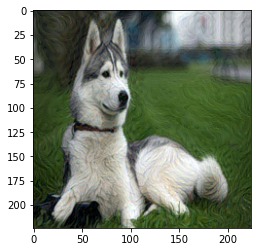

In [22]:
with torch.no_grad():
    plt.imshow(generate_tensor.cpu().squeeze().permute(1,2,0).clamp(max=1, min=0))

In [84]:
log_tensor = torch.stack(tensors_list)
log_tensor.shape

torch.Size([6, 3, 224, 224])

In [86]:
## To show the activation based on the given tensor grid.
def show_grid_tensor(grid_im, n):
    fig = plt.figure(figsize=(15,15))
    for i in range(n):
        ax = plt.subplot(5, 2, i+1)
        plt.imshow(grid_im[i].permute(1,2,0).clamp(max=1, min=0))    
        plt.axis("off")
        plt.title(f"{i}")
    plt.savefig("logs.png")
    return plt

<module 'matplotlib.pyplot' from '/home/felladog/anaconda3/envs/deep/lib/python3.8/site-packages/matplotlib/pyplot.py'>

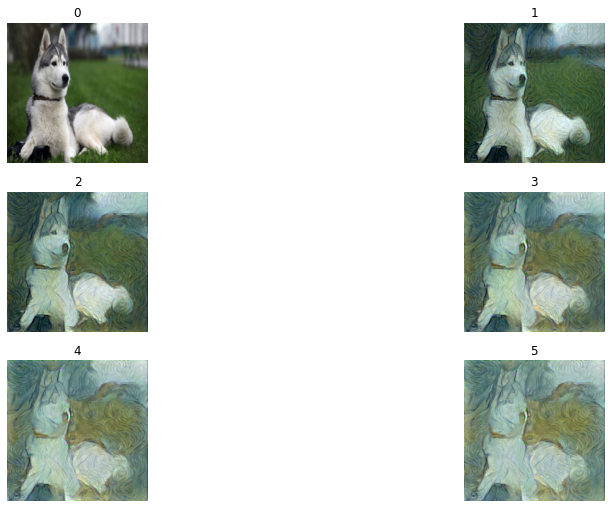

In [87]:
show_grid_tensor(log_tensor, n=6)

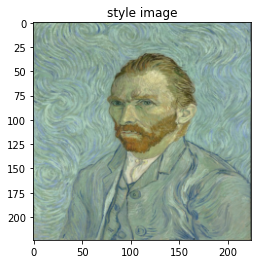

In [33]:
show_tensor(style_tensor, "style image")

In [34]:
!rm *.png